# Código Python - Trabalho 2

## *Imports* estáticos

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [19]:
dados = pd.read_csv('../../dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']).rename(columns={"Value":"Premature_Deaths"})
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

### 4.1.4. Agrupamento dos dados em zonas

In [20]:
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
soutEuDados

,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Premature_Deaths
1274,Greece,EL643,PM2.5,Chronic obstructive pulmonary disease,15469.0,243.2,7.6,0.0
1548,Portugal,PT16H,PM2.5,Chronic obstructive pulmonary disease,67529.0,1098.3,5.8,0.0
1552,Spain,ES417,PM2.5,Chronic obstructive pulmonary disease,72931.0,610.6,5.2,0.0
3094,Greece,EL412,PM2.5,Chronic obstructive pulmonary disease,26702.0,232.2,9.0,1.0
3096,Greece,EL621,PM2.5,Chronic obstructive pulmonary disease,27037.0,184.4,9.2,1.0
...,...,...,...,...,...,...,...,...
47743,Italy,IT,PM2.5,Chronic obstructive pulmonary disease,45750394.0,169657.2,11.7,4166.0
47763,Italy,IT,PM2.5,Lung cancer,45750394.0,169657.2,11.7,5373.0
47780,Italy,IT,PM2.5,Diabetes Mellitus,45750394.0,169657.2,11.7,9805.0
47787,Italy,IT,PM2.5,Ischemic heart disease,45750394.0,169657.2,11.7,10789.0


### 4.2.3 K-Fold cross validation

#### Preparação dos valores

In [21]:
goalAttrib = 'Premature_Deaths'
features = list(dados.columns[0:8])
numericFeatures = features[4:]
scaler = MinMaxScaler()

X = soutEuDados[numericFeatures].drop(columns=[goalAttrib])
y = soutEuDados[goalAttrib]

#### Otimização dos parâmetros da Árvore de regressão e visualização

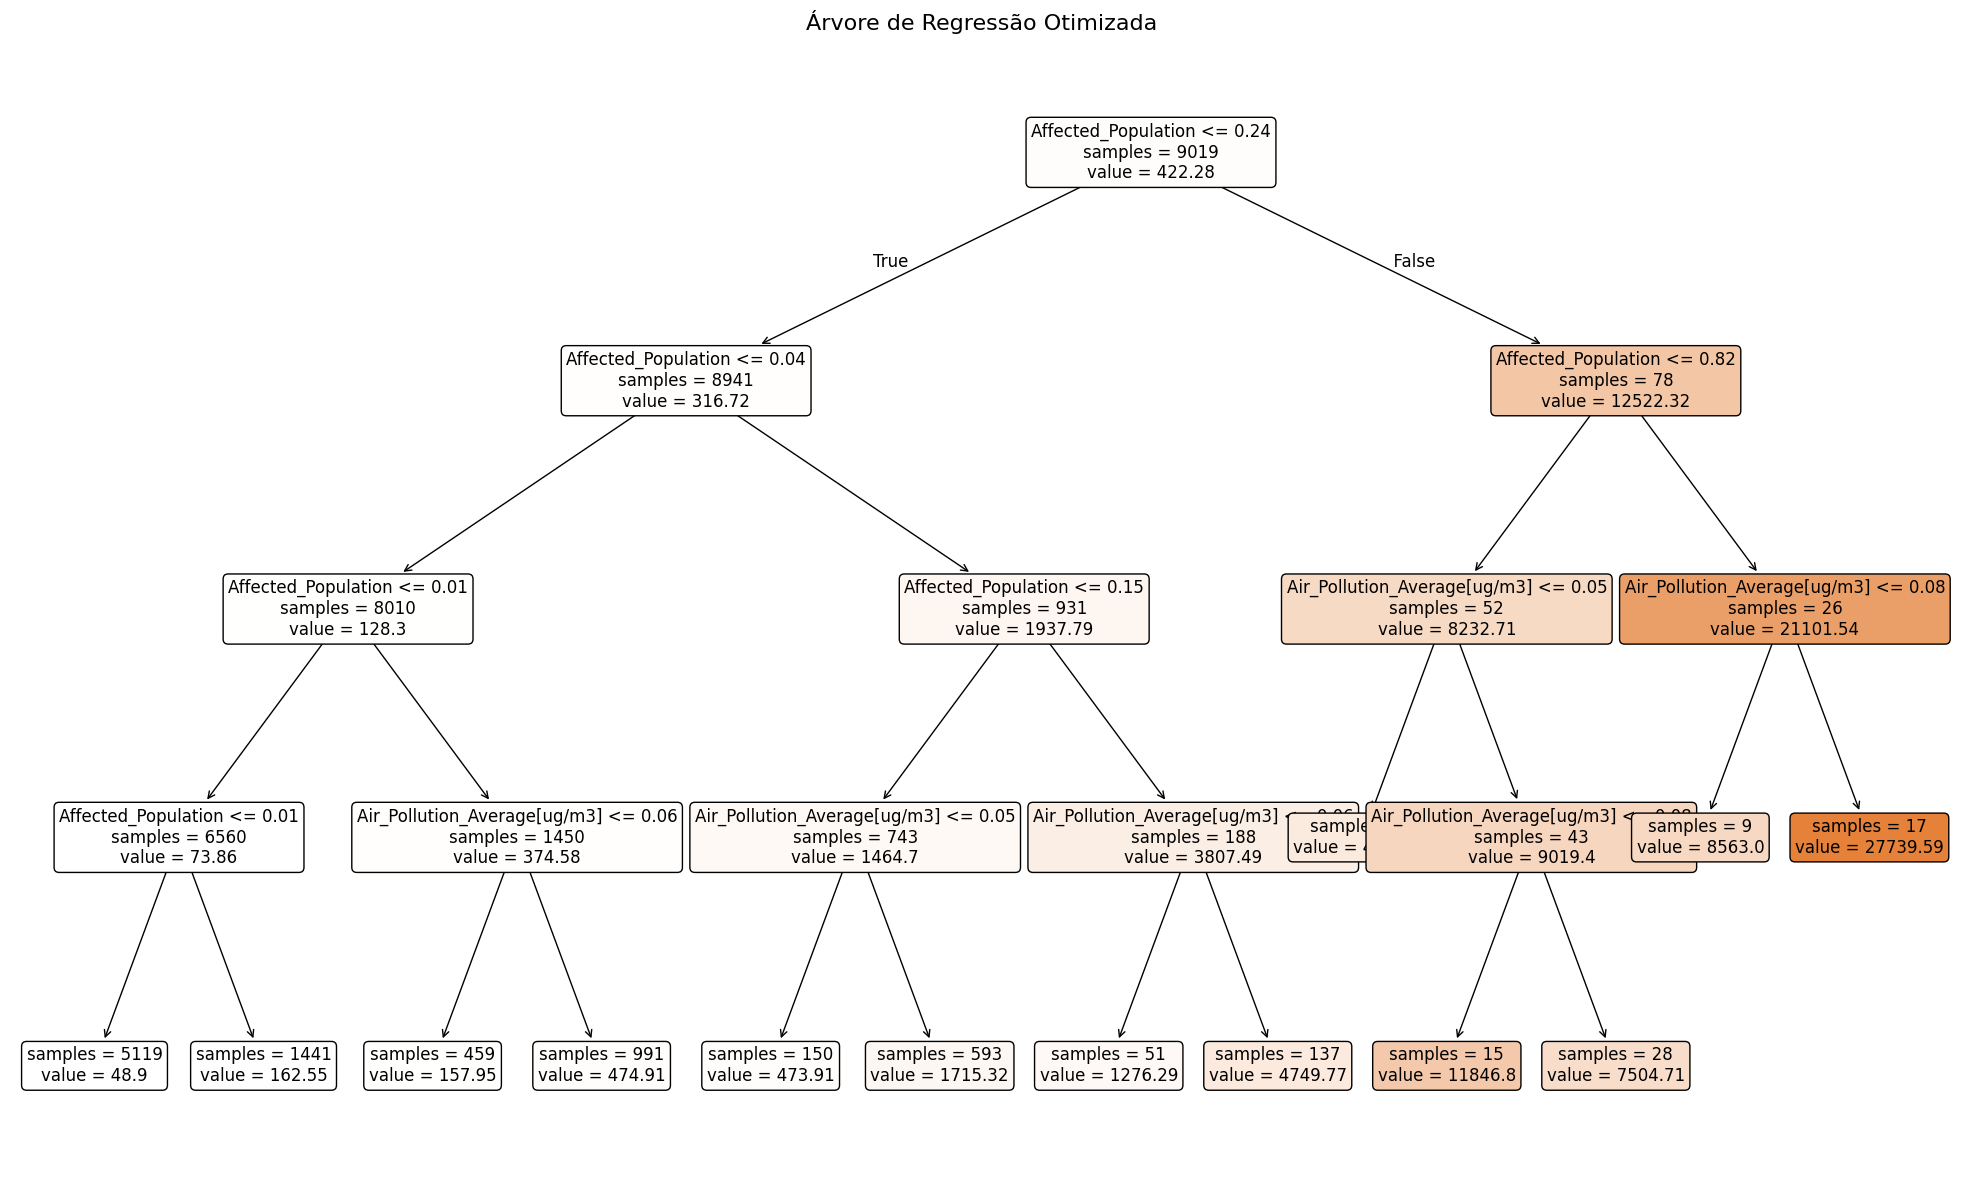

In [22]:
tree_params = {
    'dtr__max_depth': [4, 6, 8, None],
    'dtr__min_samples_split': [2, 5, 10],
    'dtr__min_samples_leaf': [1, 2, 4]
}
tree_pipeline = Pipeline([
    ('scaler', scaler),
    ('dtr', DecisionTreeRegressor(random_state=42))
])
tree_grid = GridSearchCV(tree_pipeline, tree_params, cv=3,
                         scoring='neg_mean_squared_error', n_jobs=-1)
tree_grid.fit(X, y)

#----------------------------

plt.figure(figsize=(20, 12))  

plot_tree(
    tree_grid.best_estimator_.named_steps['dtr'],
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=12,
    proportion=False,
    impurity=False,
    precision=2
)

plt.title("Árvore de Regressão Otimizada", fontsize=16)
plt.tight_layout()
plt.show()

#### Otimização do kernel SVM

In [23]:
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', SVR())
])

svm_params = {
    'svm__kernel': ['rbf'],
    'svm__C': [1, 10],
    'svm__epsilon': [0.1, 0.2]
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5,
                        scoring='neg_mean_squared_error', n_jobs=-1)
svm_grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10], 'svm__epsilon': [0.1, 0.2],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

#### Otimização da configuração da rede neuronal

In [24]:
mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['relu'],
    'mlp__solver': ['adam'],
    'mlp__learning_rate': ['constant']
}
mlp_pipeline = Pipeline([
    ('scaler', scaler),
    ('mlp', MLPRegressor(max_iter=5000, early_stopping=True, random_state=42))
])
mlp_grid = GridSearchCV(mlp_pipeline, mlp_params, cv=3,
                        scoring='neg_mean_squared_error', n_jobs=-1)
mlp_grid.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('mlp',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=5000,
                                                     random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['relu'],
                         'mlp__hidden_layer_sizes': [(50,), (100,)],
                         'mlp__learning_rate': ['constant'],
                         'mlp__solver': ['adam']},
             scoring='neg_mean_squared_error')

#### k-fold cross validation

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
models.append(('rgr', Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])))
models.append(('dtr', tree_grid.best_estimator_))
models.append(('net', mlp_grid.best_estimator_))
models.append(('svm', svm_grid.best_estimator_))

lstresults = []

for name, model in models:
    cv_scores = cross_val_score(model, X, y, cv=kfold,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = (-cv_scores) ** 0.5
    lstresults.append(pd.Series({
        'model': name,
        'mean_RMSE': round(np.mean(rmse), 3),
        'std_RMSE': round(np.std(rmse), 3)
    }))

resdf = pd.DataFrame(lstresults)
resdf

,model,mean_RMSE,std_RMSE
0,rgr,1973.718,352.331
1,dtr,1892.906,291.569
2,net,1974.829,433.163
3,svm,2289.983,511.069
